In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from LP import LP
from DeepLP import DeepLP
from DeepLP_Sparse import DeepLP_Sparse
from DeepLP_RBF import DeepLP_RBF
from DeepLP_WeightedRBF import DeepLP_WeightedRBF
from DeepLP_WeightedRBF_t import DeepLP_WeightedRBF_t

from utils import *

# Data Preparation

In [2]:
# get labels, features and weights
LX, Ly, UX, Uy, Uy_sol = get_iris_data()
features = np.vstack((LX,UX))
true_labels = np.hstack((Ly,Uy_sol))
weights = rbf_kernel(features)
num_features = features.shape[1]
num_labeled = len(Ly)
num_unlabeled = len(Uy)
num_nodes = num_labeled+num_unlabeled
graph = (weights > 0).astype(int)

In [3]:
# prepare features for NN
LY = np.tile(Ly,(Ly.shape[0],1))
np.fill_diagonal(LY, 0.5)
UY = np.tile(Uy,(Ly.shape[0],1))

masked_ = np.hstack((np.identity(LY.shape[0]),np.zeros((Ly.shape[0],Uy.shape[0]))))
true_labeled = np.array([1] * LY.shape[0] + [0] * Uy.shape[0]).reshape(1,100)

In [4]:
unlabeled_test = np.hstack((np.zeros(LY.shape[0]),np.ones((Uy.shape[0])))).reshape(1,100)
test_data = {
    'X': np.hstack((Ly,Uy)).reshape(1,100),
    'y': np.tile(true_labels,(Ly.shape[0],1))[1:2],
    'unlabeled': unlabeled_test,
    'labeled': (1 - unlabeled_test).reshape(1,100),
    'true_labeled': true_labeled,
    'masked':masked_[0:1]
}

In [5]:
unlabeled_ = np.hstack((np.identity(LY.shape[0]),np.ones((Ly.shape[0],Uy.shape[0]))))
data = {
    'X':np.hstack((LY, UY)),
    'y':np.reshape(true_labels,(1,len(true_labels))),
    'unlabeled':unlabeled_,
    'labeled':1-unlabeled_,
    'true_labeled': true_labeled,
    'masked':masked_
}

# Label Propagation

In [6]:
lp = LP()
Uy_lp = np.rint(lp.closed(features,Ly))
Uy_lp_iter = np.rint(lp.iter_(features,Ly,Uy,1000))

In [7]:
print("[Accuracy] Closed solution:", accuracy(Uy_sol, Uy_lp), " Iter Solution:", accuracy(Uy_sol, Uy_lp_iter))
print("[RMSE] Closed solution", rmse(Uy_sol, Uy_lp), " Iter solution", rmse(Uy_sol, Uy_lp))

[Accuracy] Closed solution: 0.8  Iter Solution: 0.8
[RMSE] Closed solution 0.2  Iter solution 0.2


In [8]:
# for iter_ in [1,2,3,4,5,10,100,1000]:
#     print(iter_)
#     Uy_lp_iter = np.rint(lp.iter_(features,Ly,Uy,iter_))
#     print("Objective:", objective(Ly,np.rint(Uy_lp_iter),weights))
#     print("Accuracy:", accuracy(Uy_sol,Uy_lp_iter))
#     print("RMSE:", rmse(Uy_sol,Uy_lp_iter))

In [9]:
# sess = tf.Session()
# dlps = DeepLP_Sparse(10, num_nodes, weights, 1, sess)

# DeepLP

In [10]:
sess = tf.Session()
dlp = DeepLP(10, num_nodes, weights, 1, sess)

In [11]:
pred_dlp = dlp.labelprop(test_data)
Uy_dlp = np.rint(pred_dlp[:,num_labeled:]).reshape(num_unlabeled)

In [12]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp))
print("RMSE:", rmse(Uy_sol,Uy_dlp))
print("Objective:", objective(Ly,Uy_dlp,dlp.get_value(dlp.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07189292


# DeepLP_RBF

In [13]:
sess = tf.Session()
dlp_rbf = DeepLP_RBF(10, num_nodes, features, graph, np.var(features), 0.01, sess)

In [14]:
pred_dlp_rbf = dlp_rbf.labelprop(test_data)
Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

In [15]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_value(dlp_rbf.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07191023


In [16]:
dlp_rbf.train(data,test_data,100)

epoch: -1 labeled loss: 0.295816 unlabeled loss: 0.228928 accuracy: 0.64 sol unlabeled loss: 0.219636 sol accuracy: 0.8
epoch: 0 labeled loss: 0.295355 unlabeled loss: 0.228564 accuracy: 0.644 sol unlabeled loss: 0.219145 sol accuracy: 0.8
sigma: 3.46386
epoch: 10 labeled loss: 0.289176 unlabeled loss: 0.222999 accuracy: 0.696 sol unlabeled loss: 0.211571 sol accuracy: 0.863158
epoch: 20 labeled loss: 0.283025 unlabeled loss: 0.2149 accuracy: 0.746 sol unlabeled loss: 0.198821 sol accuracy: 0.873684
epoch: 30 labeled loss: 0.282953 unlabeled loss: 0.214426 accuracy: 0.754 sol unlabeled loss: 0.197766 sol accuracy: 0.873684
epoch: 40 labeled loss: 0.282953 unlabeled loss: 0.214401 accuracy: 0.754 sol unlabeled loss: 0.197706 sol accuracy: 0.873684
epoch: 50 labeled loss: 0.282953 unlabeled loss: 0.214404 accuracy: 0.754 sol unlabeled loss: 0.197715 sol accuracy: 0.873684
epoch: 60 labeled loss: 0.282953 unlabeled loss: 0.214405 accuracy: 0.754 sol unlabeled loss: 0.197715 sol accuracy: 

In [17]:
argmax = np.argmax(dlp_rbf.accuracies)

In [18]:
pred_dlp_rbf = np.rint(dlp_rbf.pred(test_data,dlp_rbf.sigmas[argmax]))
Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

In [19]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_value(dlp_rbf.W)))

Accuracy: 0.873684210526
RMSE: 0.126315789474
Objective: 1218.36465532


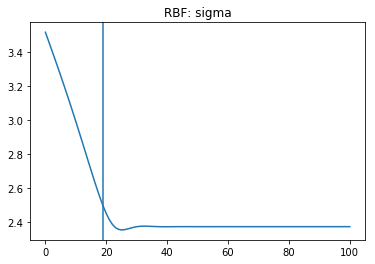

In [20]:
plt.plot(dlp_rbf.sigmas)
plt.title("RBF: sigma")
plt.axvline(x=19)
plt.show()

In [ ]:
# plt.plot(range(20,100+1),dlp_rbf.sigmas[20:])
# plt.title("RBF: sigma (iter 20-100)")
# plt.show()

In [ ]:
plt.plot(dlp_rbf.labeled_losses,label="labeled loss")
plt.plot(dlp_rbf.unlabeled_losses,label="unlabeled loss")
plt.plot(dlp_rbf.sol_unlabeled_losses,label='validation unlabeled loss')
plt.title("RBF: loss")
plt.legend()
# plt.axvline(x=19)
plt.show()

In [ ]:
# plt.plot(range(20,100+1),dlp_rbf.labeled_losses[20:],label="labeled loss")
# # plt.plot(dlp_rbf.unlabeled_losses,label="unlabeled loss")
# plt.title("RBF: labeled loss (iter 20-100)")
# plt.legend()
# plt.show()

In [10]:
# # plt.plot(range(20,100+1),dlp_rbf.labeled_losses[20:],label="labeled loss")
# plt.plot(range(20,100+1),dlp_rbf.unlabeled_losses[20:],label="unlabeled loss")
# plt.title("RBF: unlabeled loss (iter 20-100)")
# plt.legend()
# plt.show()

In [11]:
plt.plot(dlp_rbf.accuracies,label="DeepLP, train")
plt.plot([accuracy(Uy_sol,Uy_dlp)] * len(dlp_rbf.accuracies),label="LP")
plt.plot(dlp_rbf.sol_accuracies,label="DeepLP, validation")
plt.title("RBF: accuracy")
plt.legend()
plt.show()

NameError: name 'dlp_rbf' is not defined

# DeepLP_WeightedRBF

In [21]:
# theta = np.ones(num_features)
theta = np.array([ 1 ,  1,  1,  1 ])

In [22]:
sess = tf.Session()
dlp_wrbf = DeepLP_WeightedRBF(10, num_nodes, features, graph, np.var(features), theta, 0.01, sess, 0)

In [23]:
pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)

In [24]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_wrbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_wrbf))
print("Objective:", objective(Ly,Uy_dlp_wrbf,dlp_wrbf.get_value(dlp_wrbf.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07191023


In [25]:
dlp_wrbf.train(data,test_data,200)

epoch: -1 labeled loss: 0.295816 unlabeled loss: 0.228928 accuracy: 0.64 sol unlabeled loss: 0.219636 sol accuracy: 0.8
epoch: 0 labeled loss: 0.292424 unlabeled loss: 0.228116 accuracy: 0.656 sol unlabeled loss: 0.218627 sol accuracy: 0.810526
theta: [ 0.95003498  0.95008248  1.05002415  1.05001247]
epoch: 10 labeled loss: 0.264569 unlabeled loss: 0.218638 accuracy: 0.744 sol unlabeled loss: 0.204446 sol accuracy: 0.831579
theta: [ 0.48460174  0.52183414  1.52825117  1.53064001]
epoch: 20 labeled loss: 0.260622 unlabeled loss: 0.218769 accuracy: 0.754 sol unlabeled loss: 0.202601 sol accuracy: 0.831579
theta: [ 0.16138305  0.23243479  1.61747086  1.7831111 ]
epoch: 30 labeled loss: 0.259435 unlabeled loss: 0.218938 accuracy: 0.752 sol unlabeled loss: 0.203056 sol accuracy: 0.821053
theta: [ 0.03273485  0.0778629   1.56629479  2.01532674]
epoch: 40 labeled loss: 0.258224 unlabeled loss: 0.21912 accuracy: 0.752 sol unlabeled loss: 0.203384 sol accuracy: 0.8
theta: [ 0.00348573  0.019509

KeyboardInterrupt: 

In [ ]:
argmax = np.argmax(dlp_wrbf.accuracies)

In [ ]:
argmax

In [ ]:
plt.plot(dlp_wrbf.thetas)
plt.title("WRBF: theta, lambda=0")
# plt.axvline(x=argmax)
# plt.axvline(x=33)
plt.show()

In [ ]:
plt.plot(dlp_wrbf.labeled_losses,label='labeled loss')
plt.plot(dlp_wrbf.unlabeled_losses,label='unlabeled loss')
plt.plot(dlp_wrbf.sol_unlabeled_losses,label='validation unlabeled loss')
plt.title("WRBF: loss, lambda=0")
# plt.axvline(x=argmax)
# plt.axvline(x=33)
plt.legend()
plt.show()

In [ ]:
plt.plot(dlp_wrbf.accuracies,label='WRBF')
plt.plot(dlp_wrbf.sol_accuracies,label='WRBF validation')
plt.plot([accuracy(Uy_sol,Uy_dlp)] * len(dlp_wrbf.accuracies),label="LP")
plt.title("WRBF: accuracy, lambda=0")
plt.legend()
# plt.axvline(x=argmax)
# plt.axvline(x=33)
plt.show()

In [ ]:
# accuracies = []
# rmses = []
# objectives = []
# for sigma_ in sorted(sigmas):
#     sess = tf.Session()
#     dlp_rbf = DeepLP_RBF(10, num_nodes, features, graph, sigma_, 0.1, sess)
#     pred_dlp_rbf = dlp_rbf.labelprop(test_data)
#     Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)
#     print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
#     print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
#     print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_value(dlp_rbf.W)))
    
#     accuracies.append(accuracy)
#     rmses.append(rmse)
#     objectives.append(objective)
#     sess.close()


In [ ]:
from sklearn.utils.extmath import cartesian
l = np.arange(0,4.5,0.1)
l4 = [l for i in range(4)]
thetas = cartesian(l4)

In [ ]:
sess = tf.Session()

In [ ]:
accuracies = []
rmses = []
objectives = []
dlp_wrbf = DeepLP_WeightedRBF_t(10, num_nodes, features, graph, np.var(features), 'a', 0.01, sess)

In [ ]:

for i,theta_ in enumerate(thetas): 
#     print(theta_)
    if i % 1 == 0:
        print(i)
    test_data['theta'] = theta_.reshape(1,4)
    sess = tf.Session()
    
    pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
    Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)
    accuracies.append(accuracy(Uy_sol,Uy_dlp_wrbf))
    rmses.append(rmse(Uy_sol,Uy_dlp_wrbf))
#     print("Accuracy:", accuracies[-1])
#     print("RMSE:", rmses[-1])

In [ ]:
np.argmax(accuracies)

In [ ]:
thetas[6334]

In [ ]:
np.savetxt('thetas.csv',thetas,delimiter=',')

In [ ]:
np.savetxt('accuracies.csv',accuracies,delimiter=',')

In [ ]:
np.savetxt('rmses.csv',rmses,delimiter=',')

In [ ]:
accuracies = np.loadtxt('accuracies.csv',delimiter=',')

In [ ]:
thetas = np.loadtxt('thetas.csv',delimiter=',')

In [ ]:
opt = [rmse for theta,acc,rmse in zip(thetas,accuracies,rmses) if theta[0]==0.9 and theta[1]==0.9 and theta[2]==1.35 and theta[3]==0.9]

In [ ]:
for a,b in zip(thetas,accuracies):
    print(a)
    break

In [ ]:
opt

In [ ]:
np.where(thetas==[ 0.9 ,  0.9 ,  1.35,  0.9 ])

In [ ]:
thetas.shape

In [ ]:
sum(thetas==[ 0.9 ,  0.9 ,  1.35,  0.9 ])

In [ ]:
np.argmax(accuracies)

In [ ]:
thetas[6334]

In [ ]:
rmses = np.loadtxt('rmses.csv',delimiter=',')

In [ ]:
len(rmses)

In [ ]:
np.argmin(rmses)

In [ ]:
rmses[6334]

In [ ]:
from sklearn.utils.extmath import cartesian
l = np.arange(0,4.5,1.5)
l4 = [l for i in range(4)]
thetas = cartesian(l4)

In [ ]:
len(thetas)

In [ ]:
theta = np.random.uniform(0,4.5,4)

In [ ]:
w.writerow('t')

In [ ]:
w.writerow(['hi'])

In [ ]:
outfile = open('no_reg.csv', 'a')
writer=csv.writer(outfile)
# writer.writerow(np.concatenate((theta,[dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])))
writer.writerow(['theta1','theta2','theta3','theta4']+['accuracy','labeled_loss','unlabeled_loss','sol_accuracy','sol_unlabeled_loss'])
outfile.close()

In [ ]:
theta

In [ ]:
writer.writerow(np.concatenate((theta,[dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])))

In [ ]:
[dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]]

In [6]:
import time
start = time.time()
import csv 
import sys

w = csv.writer(open('no_reg.csv', 'a'), delimiter=',')
w1 = csv.writer(open('reg.csv', 'a'), delimiter=',')

i=0

sess = tf.Session()
theta = np.random.uniform(0,4.5,4)
dlp_wrbf = DeepLP_WeightedRBF(10, num_nodes, features, graph, np.var(features), theta, 0.01, sess, 0)


In [ ]:

while True:
    start = time.time()
    theta = np.random.uniform(0,4.5,4)
    print("----------------------------------")
    print("theta:",str(i),theta)
    print("----------------------------------")    
    
    dlp_wrbf.train(data,test_data,100)
    
    w.writerow([dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])
    
    print(time.time() - start)
    
    print("----------------------------------")
    start = time.time()
    dlp_wrbf.train(data,test_data,100)
    
    w1.writerow([dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])
    
    print(time.time() - start)
    
    i+=1


----------------------------------
theta: 0 [ 3.27061922  1.12900616  3.82867637  0.33171133]
----------------------------------
epoch: -1 labeled loss: 0.348925 unlabeled loss: 0.210166 accuracy: 0.652 sol unlabeled loss: 0.179179 sol accuracy: 0.8
epoch: 0 labeled loss: 0.346334 unlabeled loss: 0.208841 accuracy: 0.652 sol unlabeled loss: 0.179592 sol accuracy: 0.789474
theta: [ 3.18424988  3.63480735  1.43726611  0.55442899]
epoch: 10 labeled loss: 0.327122 unlabeled loss: 0.208769 accuracy: 0.662 sol unlabeled loss: 0.183397 sol accuracy: 0.905263
theta: [ 2.68476939  3.14782667  1.44722605  1.10289347]
epoch: 20 labeled loss: 0.307729 unlabeled loss: 0.210724 accuracy: 0.686 sol unlabeled loss: 0.188283 sol accuracy: 0.915789
theta: [ 2.17685509  2.67926264  1.43504703  1.72685826]
epoch: 30 labeled loss: 0.289572 unlabeled loss: 0.213245 accuracy: 0.728 sol unlabeled loss: 0.193624 sol accuracy: 0.863158
theta: [ 1.68793213  2.24203205  1.33526897  2.39824152]
epoch: 40 labeled l

In [ ]:
np.savetxt('sol_unlabeled_losses_fin1_1.csv',sol_unlabeled_losses1,delimiter=',')

In [ ]:
accuracies=[]
labeled_losses=[]
unlabeled_losses=[]
sol_accuracies=[]
sol_unlabeled_losses=[]
accuracies1=[]
labeled_losses1=[]
unlabeled_losses1=[]
sol_accuracies1=[]
sol_unlabeled_losses1=[]